# Tutorial for generating Al-Ti binary alloy dataset using LAMMPS.


### Authors 

#### 1. Chandramouli Nyshadham:  
        Contributions: readAllVASPFiles(), computeEnthalpy(), plotConvexHull(), get_aflowData(), plotAflowConvexHull()
#### 2. Brayden Bekker:
        Contributions: GetBinarySystem(), getHDF5() and generalising the code for computing multiple binary and ternary systems.

#### Acknowledgements: Help from Conrad Rosenbrock.
#### Adviser: Dr. Gus Hart
#### Developed as part of the MBTR project @ BYU working along with Matthias Rupp (FHI Berlin).

### The goal of this tutorial:
1. Generate any binary alloy dataset using interatomic potentails obtained from lammps. As an example in this tutorial we will generate Al-Ti binary alloy  dataset.
2. The dataset needs two essential inputs listed below.

    Inputs:
        a. [system].eam.alloy: where system is a binary or ternary system of elements from the periodic table. The potentials were gathered from the Interatomic Potentials Repository.
            (https://www.ctcms.nist.gov/potentials/).
        b. Structures_[system]/[fcc, bcc, hcp] folders: A hierarchy of directories for each each system containing derivative super structures developed with enumlib (https://github.com/msg-byu/enumlib) for fcc,bcc,hcp. 
        For this tutorial we will use 2500 derivative super structures for each crystal structure type (fcc, bcc, hcp). 
        
3. Output:
- Convex hulls plotted for the binary system 
- HDF5 with lammps energyies data. See genHDF5 function for details.


The tutorial requires certain essential python packages such as quippy, lammpslib.py, ase.

## Importing necessary packages

In [1]:
#compute total energies with:
import quippy
from lammpslib import LAMMPSlib
from aflow import *
import os
from os.path import isfile, join
import numpy as np
import collections
import matplotlib.pyplot as plt
import h5py
import itertools
import sys
from ase.optimize import BFGS, BFGSLineSearch
from ase.optimize.precon import PreconLBFGS
from tqdm import tqdm

In [2]:
def GetBinarySystem(arg1,arg2):
    '''
    Atomic Simulation Environment (ASE.py) and QUIPPY require information such as the atomic mass, number, etc.. 
    of the elements of a given system to create an atoms object and compute: energy, position, etc...
    
    This function takes as input the elements of the binary system chosen, selects the appropriate data from the 
    dictionary and returns a list of these values for use with quippy, lammps and ase.
    
    Example: 
        
        GetBinarySystem('Al','Ni')
        
    Result: ['Al', 'Ni', 26.9815, 58.6934, 13, 28]
        
    '''

    # The dictionary of all the elements on the periodic table
    elements ={"H":3.75,"AtomicMassH": 1.0079,"AtomicNumH": 1,"He": 3.57,"AtomicMassHe":4.0026,"AtomicNumHe":2, 
               "Li":3.49,"AtomicMassLi":6.941,"AtomicNumLi":3,"Be":2.29,"AtomicMassBe":9.0122,"AtomicNumBe":4,
               "B":8.73,"AtomicMassB":10.811,"AtomicNumB":5,"C": 3.57,"AtomicMassC":12.0107,"AtomicNumC":6, 
               "N":4.039,"AtomicMassN":14.0067,"AtomicNumN":7,"O":6.83,"AtomicMassO":15.9994,"AtomicNumO":8,
               "Ne":4.43,"AtomicMassNe":20.1797,"AtomicNumNe":10,"Na":4.23,"AtomicMassNa":22.9897,"AtomicNumNa":11,
               "Mg":3.21,"AtomicMassMg":24.305,"AtomicNumMg":12,"Al":4.05,"AtomicMassAl":26.9815,"AtomicNumAl":13,
               "Si":5.43,"AtomicMassSi":28.0855,"AtomicNumSi":14,"P":7.17,"AtomicMassP":30.9738,"AtomicNumP":15,
               "S":10.47,"AtomicMassS":32.065,"AtomicNumS":16,"Cl":6.24,"AtomicMassCl":35.453,"AtomicNumCl":17,
               "Ar":5.26,"AtomicMassAr":39.948,"AtomicNumAr":18,"K":5.23,"AtomicMassK":39.0983,"AtomicNumK":19, 
               "Ca":5.58,"AtomicMassCa":40.078,"AtomicNumCa":20,"Sc":3.31,"AtomicMassSc":44.9559,"AtomicNumSc":21,
               "Ti":2.95,"AtomicMassTi":47.867,"AtomicNumTi":22,"V":3.02,"AtomicMassV":50.9415,"AtomicNumV":23, 
               "Cr":2.88,"AtomicMassCr":51.9961,"AtomicNumCr":24,"Mn":8.89,"AtomicMassMn":54.938,"AtomicNumMn":25,
               "Fe":2.87,"AtomicMassFe":55.845,"AtomicNumFe":26,"Co":2.51,"AtomicMassCo":58.9332,"AtomicNumCo":27,
               "Ni":3.52,"AtomicMassNi":58.6934,"AtomicNumNi":28,"Cu":3.61,"AtomicMassCu":63.546,"AtomicNumCu":29,
               "Zn":2.66,"AtomicMassZn":65.39,"AtomicNumZn":30,"Ga":4.51,"AtomicMassGa":69.723,"AtomicNumGa":31,
               "Ge":5.66,"AtomicMassGe":72.64,"AtomicNumGe":32,"As":4.13,"AtomicMassAs":74.9216,"AtomicNumAs":33,
               "Se":4.36,"AtomicMassSe":78.96,"AtomicNumSe":34,"Br":6.67,"AtomicMassBr":79.904,"AtomicNumBr":35, 
               "Kr":5.72,"AtomicMassKr":83.8,"AtomicNumKr":36,"Rb":5.59,"AtomicMassRb":85.4678,"AtomicNumRb":37, 
               "Sr":6.08,"AtomicMassSr":87.62,"AtomicNumSr":38,"Y":3.65,"AtomicMassY":88.9059,"AtomicNumY":39, 
               "Zr":3.23,"AtomicMassZr":91.224,"AtomicNumZr":40,"Nb":3.3,"AtomicMassNb":92.9064,"AtomicNumNb":41,
               "Mo":3.15,"AtomicMassMo":95.94,"AtomicNumMo":42,"Tc":2.74,"AtomicMassTc":98,"AtomicNumTc":43, 
               "Ru":2.7,"AtomicMassRu":101.07,"AtomicNumRu":44,"Rh":3.8,"AtomicMassRh":102.9055,"AtomicNumRh":45,
               "Pd":3.89,"AtomicMassPd":106.42,"AtomicNumPd":46,"Ag":4.09,"AtomicMassAg":107.8682,"AtomicNumAg":47, 
               "Cd":2.98,"AtomicMassCd":112.411,"AtomicNumCd":48,"In":4.59,"AtomicMassIn":114.818,"AtomicNumIn":49, 
               "Sn":5.82,"AtomicMassSn":118.71,"AtomicNumSn":50,"Sb":4.51,"AtomicMassSb":121.76,"AtomicNumSb":51,
               "Te":4.45,"AtomicMassTe":127.6,"AtomicNumTe":52,"I":7.27,"AtomicMassI":126.9045,"AtomicNumI":53, 
               "Xe":6.2,"AtomicMassXe":131.293,"AtomicNumXe":54,"Cs":6.05,"AtomicMassCs":132.9055,"AtomicNumCs":55,
               "Ba":5.02,"AtomicMassBa":137.327,"AtomicNumBa":56,"Hf":3.2,"AtomicMassHf":178.49,"AtomicNumHf":72,
               "Ta":3.31,"AtomicMassTa":180.9479,"AtomicNumTa":73,"W":3.16,"AtomicMassW":183.84,"AtomicNumW":74,
               "Re":2.76,"AtomicMassRe":186.207,"AtomicNumRe":75,"Os":2.64,"AtomicMassOs":190.23,"AtomicNumOs":76,
               "Ir":3.84,"AtomicMassIr":192.217,"AtomicNumIr":77,"Pt":3.92,"AtomicMassPt":195.078,"AtomicNumPt":78,
               "Au":4.08,"AtomicMassAu":196.9665,"AtomicNumAu":79,"Hg":2.99,"AtomicMassHg":200.59,"AtomicNumHg":80,
               "Tl":3.46,"AtomicMassTl":204.3833,"AtomicNumTl":81,"Pb":4.95,"AtomicMassPb":207.2,"AtomicNumPb":82,
               "Bi":4.75,"AtomicMassBi":208.9804,"AtomicNumBi":83,"Sm":3.62,"AtomicMassSm":150.36,"AtomicNumSm":62} 

    element1="%s"%(arg1) #(e.g. Al) Get the element name from the arguments.
    element2="%s"%(arg2)
    mass1="AtomicMass%s"%(arg1) #(e.g. 26.9815) Get the atomic mass of the first element.
    mass2="AtomicMass%s"%(arg2)
    number1="AtomicNum%s"%(arg1) #(e.g. 13) Get the atomic number of the first element.
    number2="AtomicNum%s"%(arg2)
    #A list of the important atomic information for the given elements.
    system = [element1,element2,elements[mass1],elements[mass2],elements[number1],elements[number2]]
    return system

In [3]:
def readAllVASPFiles(paths,potential,AtomicNum,numStructToRead=9):
    """
    This fuction reads in all the crystal structures in the path to folder given. All the input files should be in
    vasp format. 
    
    The function returns atom numbers, positions(cartesian coordinates), and total energies computed using the
    potential.
    
    Arguments:
        Input: 
            path (string): path to the folder where all strucutres (vasp files) are present
            numStructToRead (int): if FALSE all files in the folder are read,else only 'numStructToRead' are read.
            potential: potential for computing the total energies.
            AtomicNum: Array containing elements atomic numbers.
            numStructToRead:  for testing purpose you can ask it to read only few files of each crystal type.
            
        output:
            Returns a dictionary containing
            
            z (np.array): atomic nuclear charge
            un_pos (np.array): unrelaxed positions  of all atoms in a crystal structure. (cartesian) 
            rel_pos (np.array): relaxed positions  of all atoms in a crystal structure. (cartesian) 
            lattice (np.array): lattice vectors of the unit cell. 
            un_TEnePA (np.array): unrelaxed total energy per atom of crystal structure computed using potential.
            rel_TEnePA (np.array): relaxed total energy per atom of crystal structure computed using potential.
            structInfo (np.array): contains the structure information (file number).
            conc (np.array): concentration of element A in the binary AB (listed in alphabetical order) 
            forces (np.array): the total forces computed while relaxing the structure. 
            
    Note: All files in the folder should be named in the format, 'vasp.1', 'vasp.3', ... etc. which is what enumlib 
            generates.
    """
    
    AtomicNumA=AtomicNum[0]
    AtomicNumB=AtomicNum[1]

    
    res_z=[] # nuclear charge
    res_pos=[]# unrelaxed positions (cartesian)
    res_lattice=[]# lattice vectors
    res_totEnePerAtom=[] # total energy per atom
    res_structInfo=[] # file name of vasp structure
    res_conc=[] # concentration
    
    res_forces=[] # forces obtained after relaxation
    res_rel_pos=[] # relaxed positions (cartesian)
    res_rel_ene=[] # relaxed total energy per atom

    res={}

    atomsList=quippy.AtomsList()

    for path in paths:

        for i,f  in enumerate(tqdm(os.listdir(path))):
            
            inpFile=join(path,f) # get the file name
            a = quippy.Atoms(inpFile, format="vasp") # read the input file as quippy object 
            a1 = a.copy()
            
            #atomsList.append(a)
            res_z.append(a.z) # get nuclear charge
            res_lattice.append(np.array(a.get_cell()))  # get lattice vectors
            conc=a.z.tolist().count(AtomicNumB)/float(len(a.z)) # get the concentration.
            res_conc.append(conc)
            res_structInfo.append(path[-4::]+str(f)) # structure information a.k.a file name.
            
            
            # Computing unrelaxed energies
            a.set_calculator(potential)
            res_pos.append(np.array(a.get_positions())) # get unrelaxed positions in cartesian
            totalNumOfAtoms=len(a.z) # total number of atoms
            res_totEnePerAtom.append(a.get_total_energy()/float(len(a.z))) # compute total energy per atom

            # Computing relaxed positions forces and energies 
            # performing relaxation using BFGSLineSearch
            a1.set_calculator(potential)
            opt = BFGSLineSearch(a1,logfile=None)
            opt.run(fmax=1e-5)
            res_rel_pos.append(a1.get_positions()) # get relaxed positions in cartesian
            res_forces.append(a1.get_total_energy())
            res_rel_ene.append(a1.get_total_energy()/float(len(a1.z))) # compute total energy per atom
            
            #print i, f ,"structure done"
            
            if i==numStructToRead:
                #print path, "done"
                break
                
    res={'structInfo':np.array(res_structInfo),'z':np.array(res_z),'un_pos':np.array(res_pos),'rel_pos':np.array(res_rel_pos),'lattice':np.array(res_lattice),'un_TEnePA':np.array(res_totEnePerAtom),'rel_TEnePA':np.array(res_rel_ene),'forces':np.array(res_forces), 'conc':np.array(res_conc)}

    return res #,atomsList

In [4]:
# loading the interatomic potential.

header = ["units metal",
          "dimension 3",
          "boundary p p p",
          "atom_style atomic",
          "atom_modify map array"]
cmds = ["pair_style adp",
        "pair_coeff * * /root/codes/GenLAMMPSData/Zope-Ti-Al-2003.eam.alloy Al Ti", # change this
        "mass 1 26.981539", #Al
        "mass 2 47.867", #Ti
        "neighbor 2.0 bin",
        "neigh_modify delay 10 check yes"]
pot = LAMMPSlib(lmpcmds=cmds, atom_types={"Al": 1, "Ti": 2}, # change this
                lammps_header=header, keep_alive=True)

In [5]:
pathToDirectories=os.getcwd()
folders=[pathToDirectories+str(i) for i in ['/Structures_AlTi/FCC/','/Structures_AlTi/BCC/','/Structures_AlTi/HCP/']]
folders

['/root/codes/GenLAMMPSData/Structures_AlTi/FCC/',
 '/root/codes/GenLAMMPSData/Structures_AlTi/BCC/',
 '/root/codes/GenLAMMPSData/Structures_AlTi/HCP/']

In [6]:
system=GetBinarySystem('Al','Ti')

In [7]:
data=readAllVASPFiles(folders,potential=pot,AtomicNum=[int(system[4]), int(system[5])],numStructToRead=2500)

100%|██████████| 2499/2499 [1:01:48<00:00,  1.48s/it]


In [137]:
def computeEnthalpy(data):
    """
    
    Input:
    data : Dictionary generated using 
    readAllVASPFiles(paths,potential,numStructToRead=0,AtomicNum=[29,73]) function.'
    
    Output:
    enthalpy added to dictionary 'data'.
    
    """
    
    res_enthalpy=[]
    res_rel_enthalpy=[]
    
    # compute the lowest total energies of pure elements.
    #--------Un Relaxed energies
    # element A with concentration 0.0
    index=[i for i,x in enumerate(data['conc']) if x == 0.0]
    fileNum=list(data['un_TEnePA']).index(np.array(data['un_TEnePA'])[index].min())
    ene_A=data['un_TEnePA'][fileNum]
    print "UnRelaxed:","element A", data['structInfo'][fileNum], data['un_TEnePA'][fileNum]
    
    # element B with concentration 1.0
    index=[i for i,x in enumerate(data['conc']) if x == 1.0]
    fileNum=list(data['un_TEnePA']).index(np.array(data['un_TEnePA'])[index].min())
    ene_B=data['un_TEnePA'][fileNum]
    print "UnRelaxed:","element B", data['structInfo'][fileNum], data['un_TEnePA'][fileNum]
    
    
    #------- Relaxed energies
    # element A with concentration 0.0
    indexR=[i for i,x in enumerate(data['conc']) if x == 0.0]
    fileNumR=list(data['rel_TEnePA']).index(np.array(data['rel_TEnePA'])[indexR].min())
    ene_RA=data['rel_TEnePA'][fileNumR]
    print "Relaxed:","element A", data['structInfo'][fileNumR], data['rel_TEnePA'][fileNumR]
    
    # element B with concentration 1.0
    indexR=[i for i,x in enumerate(data['conc']) if x == 1.0]
    fileNumR=list(data['rel_TEnePA']).index(np.array(data['rel_TEnePA'])[indexR].min())
    ene_RB=data['rel_TEnePA'][fileNumR]
    print "Relaxed:","element B", data['structInfo'][fileNumR], data['rel_TEnePA'][fileNumR]
    
    
    # compute formation enthalpy per atom.
    # formulae: \Delta Hf = total_energy_per_atom_of_structure - sum_of_total_energies_of pure_elements
    
    for i in range(len(data['conc'])):
        enthalpy = data['un_TEnePA'][i] - (1-data['conc'][i])*float(ene_A)  - (data['conc'][i])*ene_B
        res_enthalpy.append(enthalpy)
        
    for i in range(len(data['conc'])):
        enthalpyR = data['rel_TEnePA'][i] - (1-data['conc'][i])*float(ene_RA)  - (data['conc'][i])*ene_RB
        res_rel_enthalpy.append(enthalpyR)
        
    
    return np.array(res_enthalpy),np.array(res_rel_enthalpy)

Once we have all the relaxed energies computed. We then need to calculte the enthalpy per atom. 

In [138]:
Unrel_EnthalpyPA,rel_EnthalpyPA=computeEnthalpy(data)

UnRelaxed: element A FCC/vasp.1 -3.36000002859
UnRelaxed: element B HCP/vasp.3 -4.84285495739
Relaxed: element A FCC/vasp.1 -3.36000002859
Relaxed: element B HCP/vasp.3 -4.84285495739


Apparantly, in this case the relaxed and unrelaxed energies of pure Al and pure Ti are same. They did not change. In general the relaxed energies are smaller than unrelaxed.

Updating the data dictionary with relaxed enthalpy per atom.

In [136]:
data.update({'Unrel_EntPA':Unrel_EnthalpyPA})
data.update({'rel_EntPA':rel_EnthalpyPA})

In [184]:
def plotConvexHull(data,title,ylim=None,EneType="rel"):
    """
    Plots the convex hull.
    """
    if EneType=="Unrel":
        fccNum=len(filter(lambda x:'FCC' in x, data['structInfo']))
        bccNum=len(filter(lambda x:'BCC' in x, data['structInfo']))
        hcpNum=len(filter(lambda x:'HCP' in x, data['structInfo']))      
        # plotting the convex hull
        plt.figure()
        plt.scatter(data['conc'][0:fccNum-1],data['Unrel_EntPA'][0:fccNum-1],label='fcc')
        plt.scatter(data['conc'][fccNum:fccNum+bccNum-1],data['Unrel_EntPA'][fccNum:fccNum+bccNum-1],label='bcc')
        plt.scatter(data['conc'][-hcpNum:],data['Unrel_EntPA'][-hcpNum:],label='hcp')
        plt.title(title)
        plt.xlim(0,1)
        if ylim:
            plt.ylim(ylim[0],ylim[1]) #increased res of variation at bottom of convex hull.
        plt.legend()
        #plt.savefig("ConvexHull%s.pdf"%(title), format="pdf")
        plt.savefig("ConvexHull2%s.png"%(title), format="png")
        plt.show()
    else:
        fccNum=len(filter(lambda x:'FCC' in x, data['structInfo']))
        bccNum=len(filter(lambda x:'BCC' in x, data['structInfo']))
        hcpNum=len(filter(lambda x:'HCP' in x, data['structInfo']))      
        # plotting the convex hull
        plt.figure()
        plt.scatter(data['conc'][0:fccNum-1],data['rel_EntPA'][0:fccNum-1],label='fcc')
        plt.scatter(data['conc'][fccNum:fccNum+bccNum-1],data['rel_EntPA'][fccNum:fccNum+bccNum-1],label='bcc')
        plt.scatter(data['conc'][-hcpNum:],data['rel_EntPA'][-hcpNum:],label='hcp')
        plt.title(title)
        plt.xlim(0,1)
        if ylim:
            plt.ylim(ylim[0],ylim[1]) #increased res of variation at bottom of convex hull.
        plt.legend()
        #plt.savefig("ConvexHull%s.pdf"%(title), format="pdf")
        plt.savefig("ConvexHull2%s.png"%(title), format="png")
        plt.show()
        

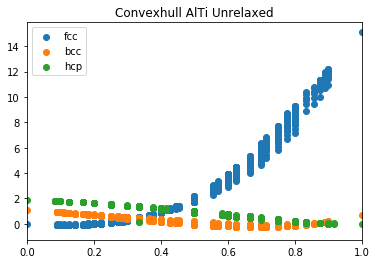

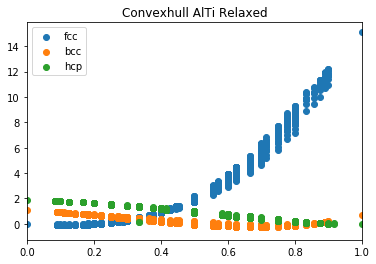

In [185]:
plotConvexHull(data,title="Convexhull AlTi Unrelaxed",EneType="Unrel")
plotConvexHull(data,title="Convexhull AlTi Relaxed",EneType="Unrel")

Let us have a closer look at y-axis range around zero

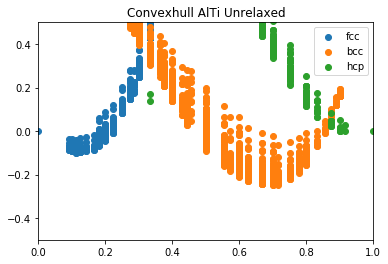

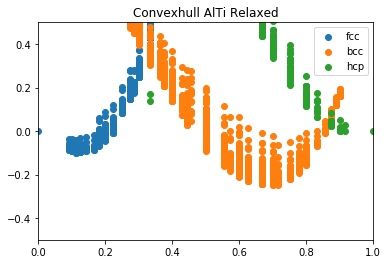

In [187]:
plotConvexHull(data,title="Convexhull AlTi Unrelaxed",ylim=[-0.5,0.5],EneType="Unrel")
plotConvexHull(data,title="Convexhull AlTi Relaxed",ylim=[-0.5,0.5],EneType="Unrel")

Let us save the data and use it for MBTR later.

In [200]:
np.save("AlTi-Lammps",data)

In [201]:
dd=np.load("AlTi-Lammps.npy").item()

## Let us compare our convex hull and results for AlTi binary system with data in AFLOW repository.

In [191]:
aflowList= search().filter(K.species=="Al,Ti").filter(K.nspecies==2).orderby(K.enthalpy_formation_atom)

In [192]:
totalStruct=len(aflowList)
totalStruct

283

There are a total of 283  DFT calculations for this system in AFLOW repo.

In [190]:
   
def get_aflowData(totalStruct,listt):
    """
    Collects AFLOW data for a binary alloy containing species1 and species2
    
    """
    
    resConc=[]
    resEnt=[]  
    
    global aflowListt
    
    for i in range(totalStruct):
            
        entry=listt[i]
        resConc.append(entry.stoichiometry[0])
        resEnt.append(entry.enthalpy_formation_atom)
        
        
    return resConc,resEnt

In [193]:
Aconc,AEnt=get_aflowData(totalStruct,aflowList)

In [197]:
def plotAflowConvexHull(res1,res2,title):
    # plotting the convex hull.
    plt.figure()
    plt.scatter(res1,res2,s=10,label='alowData')
    plt.xlim(0,1)
    plt.ylim(-1,3)
    plt.legend()
    plt.title(title)
    #plt.savefig("Aflow%s.pdf"%(title), format="pdf") 
    plt.savefig("Aflow2%s.png"%(title), format="png")
    plt.show()

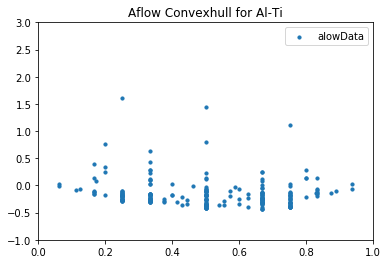

In [199]:
plotAflowConvexHull(Aconc,AEnt,"Aflow Convexhull for Al-Ti")

In [207]:
np.sum(np.abs(data['rel_EntPA']-data['Unrel_EntPA']))/len(data['rel_EntPA'])

0.38505832470042445

In [209]:
AlTiData = np.load('AlTi7500.npy').item()

In [212]:
AlTiData.keys()

['structInfo', 'totEnePerAtom', 'pos', 'enthalpy', 'lattice', 'conc', 'z']

In [1]:
i="Al"
len(i)

2